# VisDrone Dataset Exploration
This notebook explores the drone detection dataset in YOLO format.

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import yaml
from collections import Counter
import random

## 1. Load Dataset Configuration

In [3]:
# Dataset path
dataset_path = Path('data/visdrone_yolo')

# Load data.yaml if exists
yaml_path = dataset_path / 'visdrone_config.yaml'
if yaml_path.exists():
    with open(yaml_path, 'r') as f:
        data_config = yaml.safe_load(f)
    print("Dataset Configuration:")
    print(data_config)
    class_names = data_config.get('names', [])
else:
    print("data.yaml not found. Using default configuration.")
    class_names = ['drone']

Dataset Configuration:
{'path': 'data/visdrone_yolo', 'train': 'images/train', 'val': 'images/val', 'test': 'images/test', 'nc': 3, 'names': {0: 'Person', 1: 'Vehicle', 2: 'Cycle'}}


## 2. Dataset Statistics

In [5]:
def get_dataset_stats(split='train'):
    """Get statistics for a dataset split"""
    images_dir = dataset_path / 'images' / split
    labels_dir = dataset_path / 'labels' / split
    
    if not images_dir.exists():
        print(f"{split} split not found")
        return None
    
    image_files = list(images_dir.glob('*.jpg')) + list(images_dir.glob('*.png'))
    label_files = list(labels_dir.glob('*.txt')) if labels_dir.exists() else []
    
    stats = {
        'split': split,
        'num_images': len(image_files),
        'num_labels': len(label_files),
        'image_files': image_files,
        'label_files': label_files
    }
    
    return stats

# Get statistics for all splits
splits = ['train', 'val', 'test']
all_stats = {}

for split in splits:
    stats = get_dataset_stats(split)
    if stats:
        all_stats[split] = stats
        print(f"\n{split.upper()} Set:")
        print(f"  Images: {stats['num_images']}")
        print(f"  Labels: {stats['num_labels']}")


TRAIN Set:
  Images: 6471
  Labels: 6471

VAL Set:
  Images: 548
  Labels: 548

TEST Set:
  Images: 1610
  Labels: 1610


## 3. Analyze Annotations

In [6]:
def analyze_annotations(label_files):
    """Analyze YOLO format annotations"""
    class_counts = Counter()
    bbox_widths = []
    bbox_heights = []
    total_objects = 0
    
    for label_file in label_files:
        with open(label_file, 'r') as f:
            lines = f.readlines()
            for line in lines:
                parts = line.strip().split()
                if len(parts) >= 5:
                    class_id = int(parts[0])
                    width = float(parts[3])
                    height = float(parts[4])
                    
                    class_counts[class_id] += 1
                    bbox_widths.append(width)
                    bbox_heights.append(height)
                    total_objects += 1
    
    return {
        'class_counts': class_counts,
        'bbox_widths': bbox_widths,
        'bbox_heights': bbox_heights,
        'total_objects': total_objects
    }

# Analyze each split
for split, stats in all_stats.items():
    if stats['label_files']:
        analysis = analyze_annotations(stats['label_files'])
        print(f"\n{split.upper()} Annotations:")
        print(f"  Total objects: {analysis['total_objects']}")
        print(f"  Class distribution:")
        for class_id, count in analysis['class_counts'].items():
            class_name = class_names[class_id] if class_id < len(class_names) else f"Class {class_id}"
            print(f"    {class_name}: {count}")
        
        all_stats[split]['analysis'] = analysis


TRAIN Annotations:
  Total objects: 313558
  Class distribution:
    Vehicle: 183549
    Cycle: 50672
    Person: 79337

VAL Annotations:
  Total objects: 33873
  Class distribution:
    Vehicle: 17858
    Cycle: 7171
    Person: 8844

TEST Annotations:
  Total objects: 69257
  Class distribution:
    Vehicle: 35746
    Cycle: 12505
    Person: 21006


## 4. Visualize Class Distribution

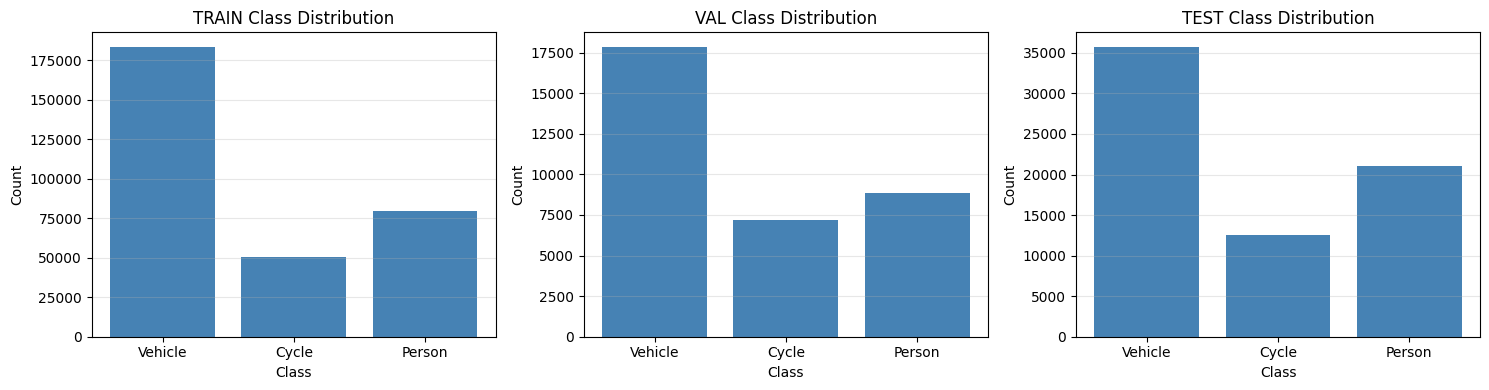

In [7]:
fig, axes = plt.subplots(1, len(all_stats), figsize=(5*len(all_stats), 4))
if len(all_stats) == 1:
    axes = [axes]

for idx, (split, stats) in enumerate(all_stats.items()):
    if 'analysis' in stats:
        analysis = stats['analysis']
        class_ids = list(analysis['class_counts'].keys())
        counts = list(analysis['class_counts'].values())
        labels = [class_names[i] if i < len(class_names) else f"Class {i}" for i in class_ids]
        
        axes[idx].bar(labels, counts, color='steelblue')
        axes[idx].set_title(f'{split.upper()} Class Distribution')
        axes[idx].set_xlabel('Class')
        axes[idx].set_ylabel('Count')
        axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Visualize Bounding Box Sizes

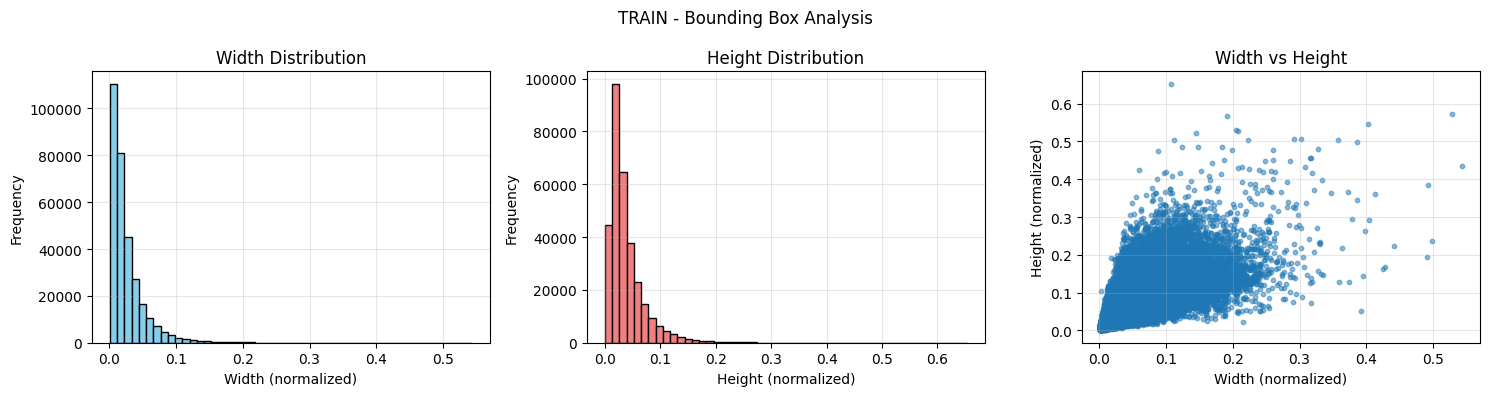

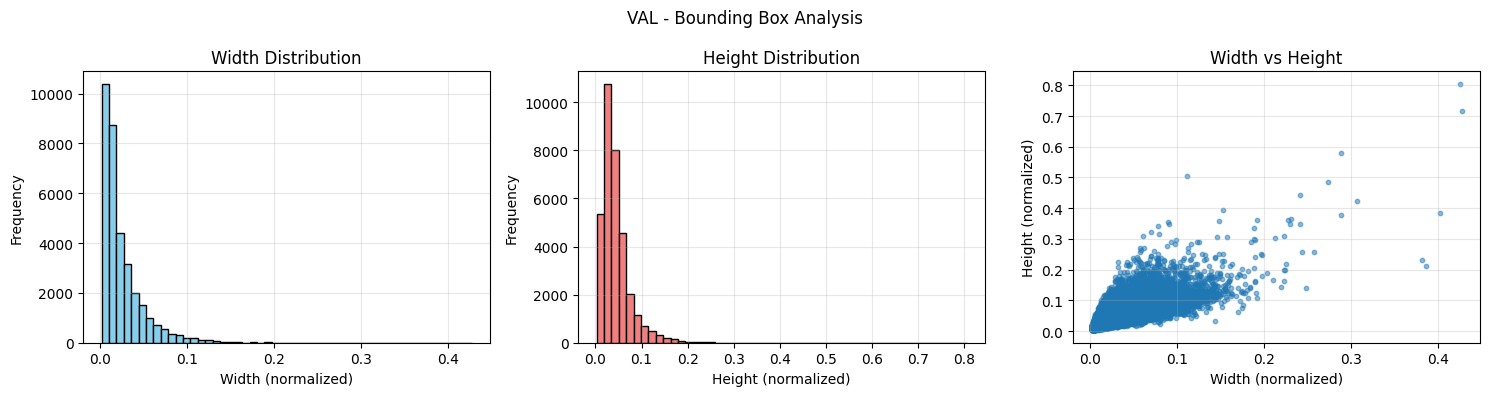

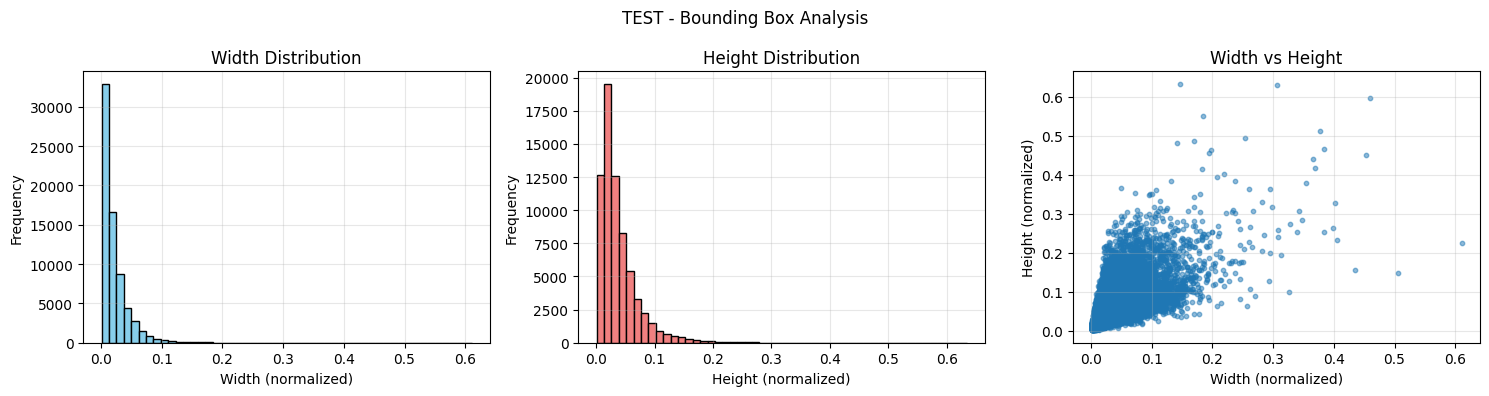

In [8]:
for split, stats in all_stats.items():
    if 'analysis' in stats:
        analysis = stats['analysis']
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        fig.suptitle(f'{split.upper()} - Bounding Box Analysis')
        
        # Width distribution
        axes[0].hist(analysis['bbox_widths'], bins=50, color='skyblue', edgecolor='black')
        axes[0].set_title('Width Distribution')
        axes[0].set_xlabel('Width (normalized)')
        axes[0].set_ylabel('Frequency')
        axes[0].grid(alpha=0.3)
        
        # Height distribution
        axes[1].hist(analysis['bbox_heights'], bins=50, color='lightcoral', edgecolor='black')
        axes[1].set_title('Height Distribution')
        axes[1].set_xlabel('Height (normalized)')
        axes[1].set_ylabel('Frequency')
        axes[1].grid(alpha=0.3)
        
        # Width vs Height scatter
        axes[2].scatter(analysis['bbox_widths'], analysis['bbox_heights'], alpha=0.5, s=10)
        axes[2].set_title('Width vs Height')
        axes[2].set_xlabel('Width (normalized)')
        axes[2].set_ylabel('Height (normalized)')
        axes[2].grid(alpha=0.3)
        
        plt.tight_layout()
        plt.show()

## 6. Visualize Sample Images with Annotations


TRAIN Samples:


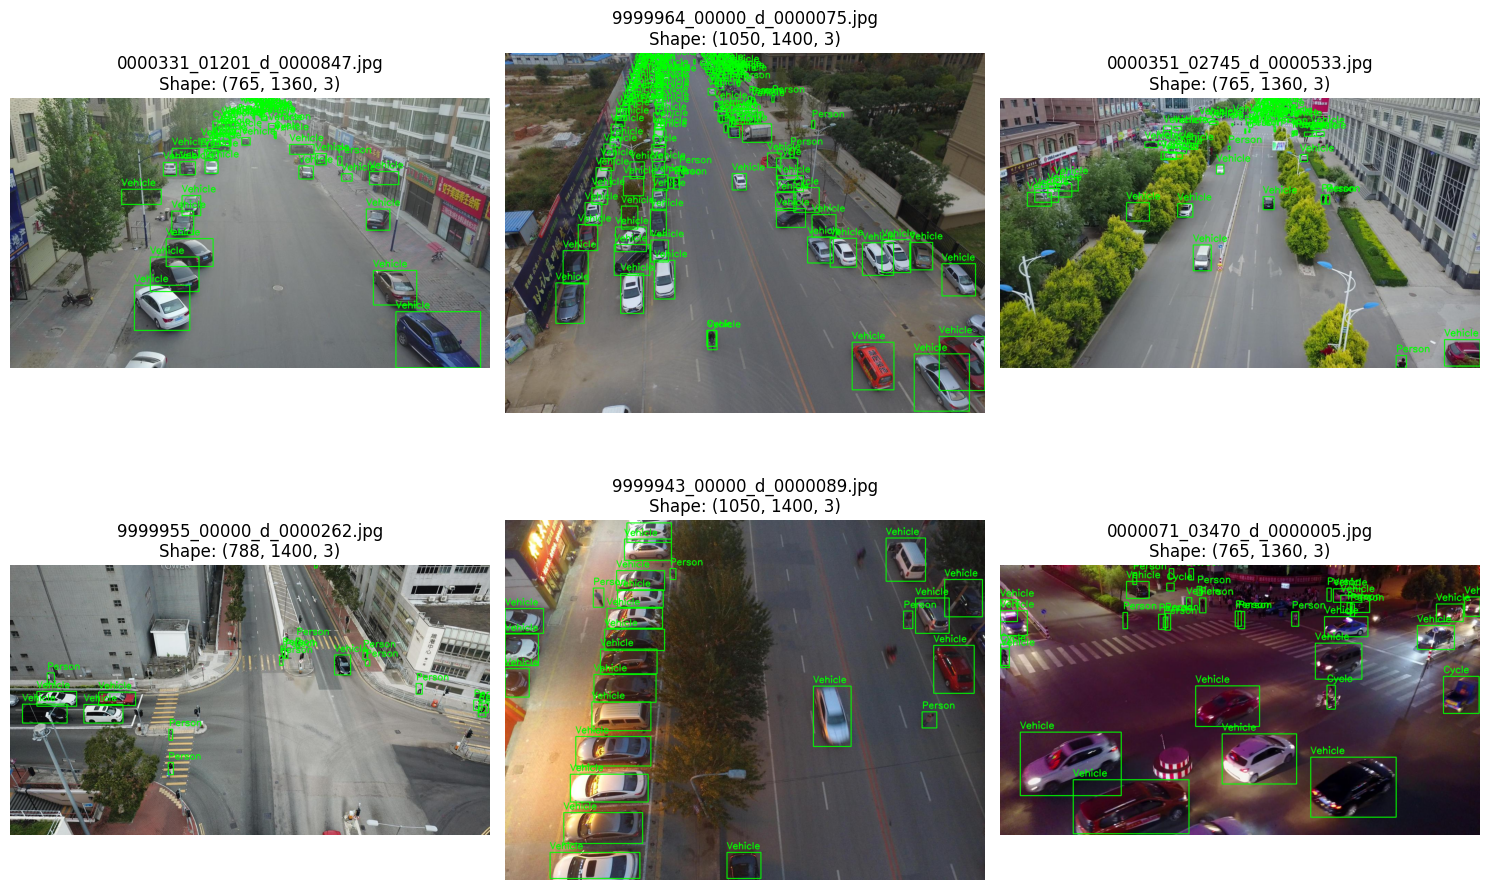


VAL Samples:


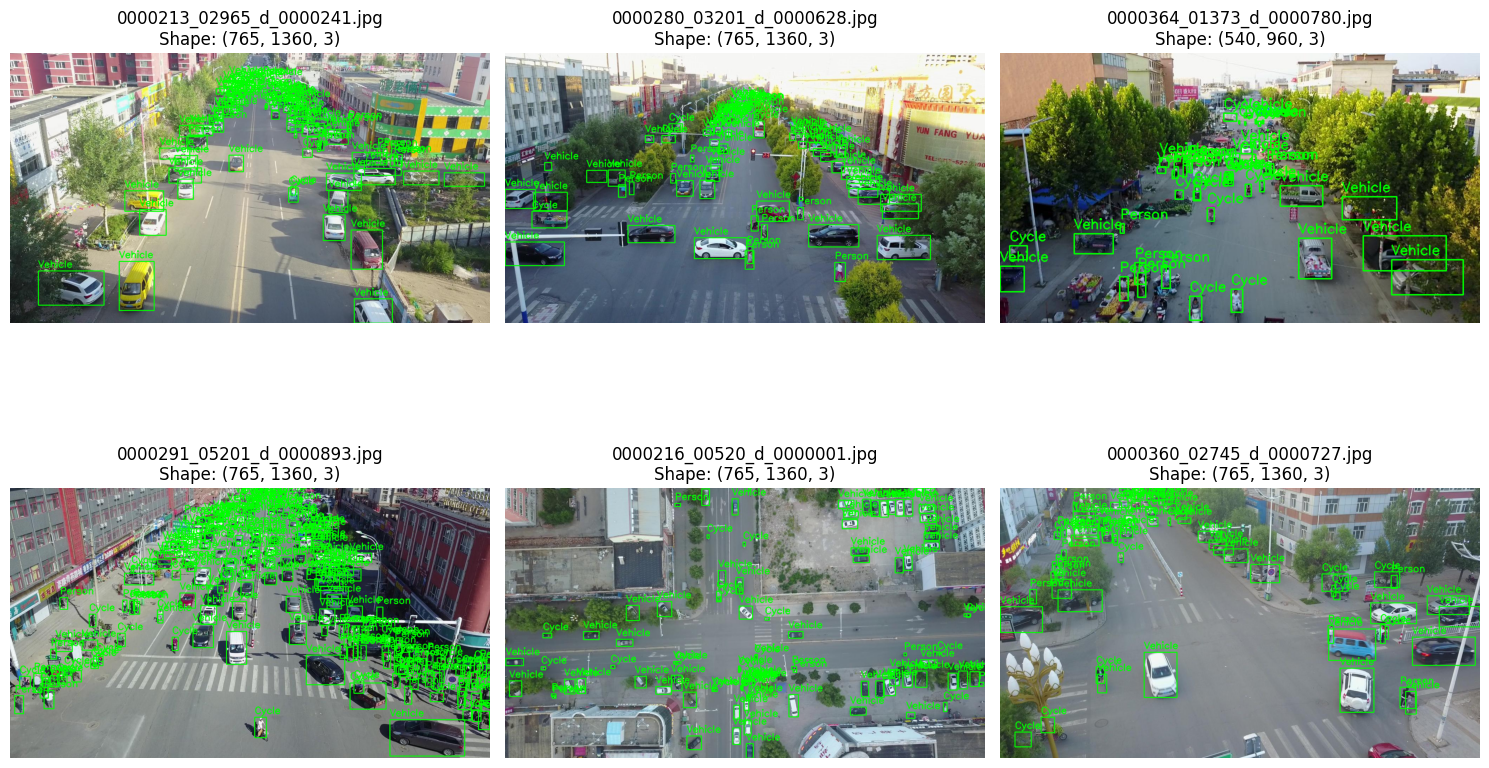


TEST Samples:


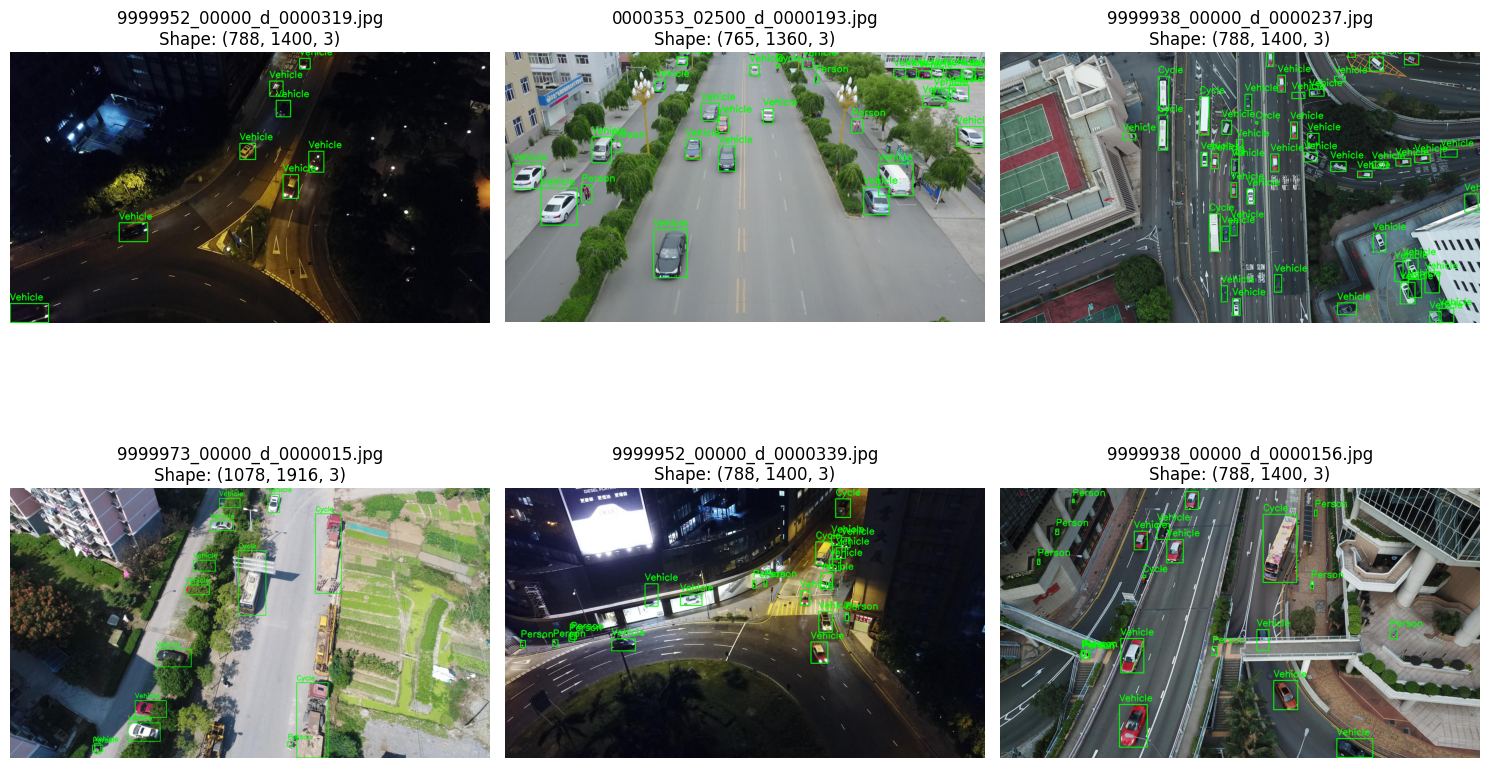

In [9]:
def draw_yolo_boxes(image, label_file, class_names):
    """Draw YOLO format bounding boxes on image"""
    img = image.copy()
    h, w = img.shape[:2]
    
    if label_file.exists():
        with open(label_file, 'r') as f:
            lines = f.readlines()
            for line in lines:
                parts = line.strip().split()
                if len(parts) >= 5:
                    class_id = int(parts[0])
                    x_center = float(parts[1]) * w
                    y_center = float(parts[2]) * h
                    width = float(parts[3]) * w
                    height = float(parts[4]) * h
                    
                    x1 = int(x_center - width / 2)
                    y1 = int(y_center - height / 2)
                    x2 = int(x_center + width / 2)
                    y2 = int(y_center + height / 2)
                    
                    class_name = class_names[class_id] if class_id < len(class_names) else f"Class {class_id}"
                    
                    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    cv2.putText(img, class_name, (x1, y1 - 10), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    
    return img

def visualize_samples(split='train', num_samples=6):
    """Visualize random samples from a split"""
    if split not in all_stats:
        print(f"{split} split not available")
        return
    
    stats = all_stats[split]
    image_files = stats['image_files']
    
    if not image_files:
        print(f"No images found in {split} split")
        return
    
    sample_files = random.sample(image_files, min(num_samples, len(image_files)))
    
    rows = (len(sample_files) + 2) // 3
    fig, axes = plt.subplots(rows, 3, figsize=(15, 5*rows))
    axes = axes.flatten() if rows > 1 else [axes] if len(sample_files) == 1 else axes
    
    for idx, img_path in enumerate(sample_files):
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        label_path = dataset_path / 'labels' / split / (img_path.stem + '.txt')
        img_with_boxes = draw_yolo_boxes(img, label_path, class_names)
        
        axes[idx].imshow(img_with_boxes)
        axes[idx].set_title(f'{img_path.name}\nShape: {img.shape}')
        axes[idx].axis('off')
    
    # Hide unused subplots
    for idx in range(len(sample_files), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize samples from each split
for split in all_stats.keys():
    print(f"\n{split.upper()} Samples:")
    visualize_samples(split, num_samples=6)

## 7. Image Size Distribution


TRAIN Image Sizes:
  Average: 1515 x 1007
  Min: 960 x 540
  Max: 2000 x 1500


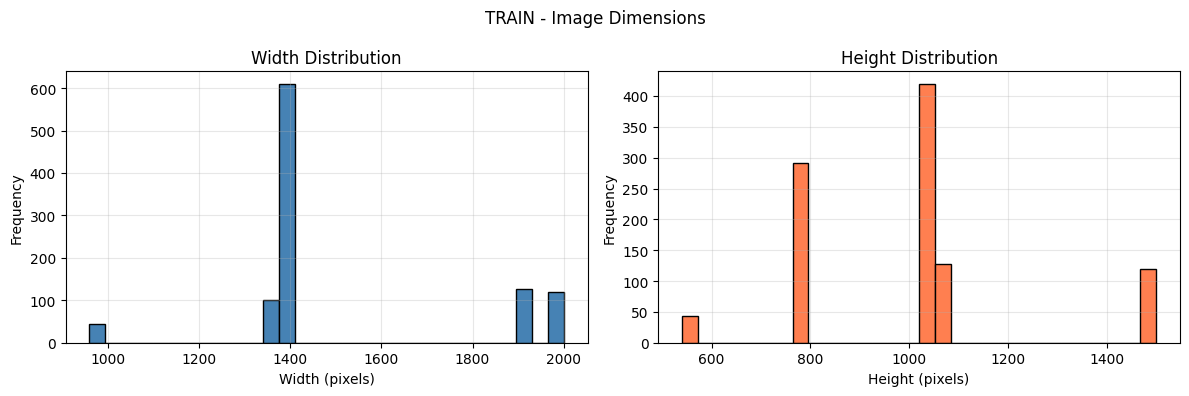


VAL Image Sizes:
  Average: 1291 x 726
  Min: 960 x 540
  Max: 1920 x 1080


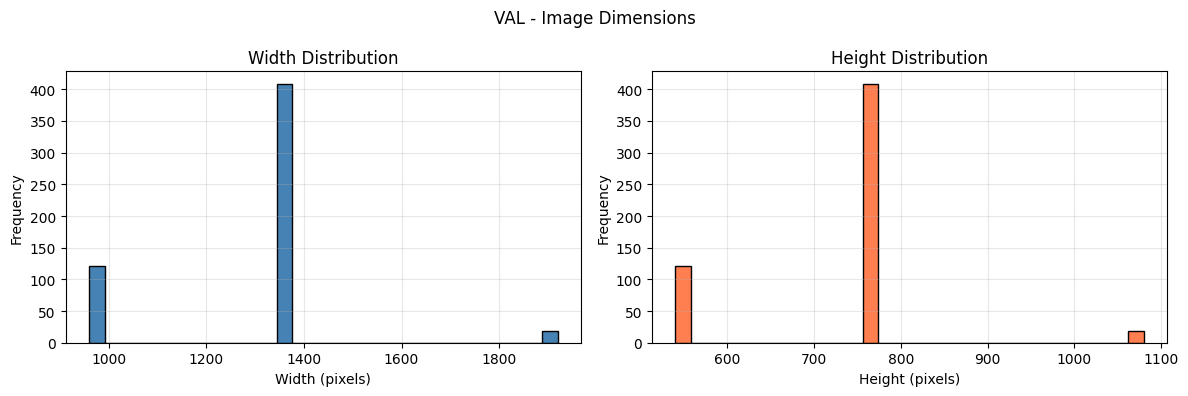


TEST Image Sizes:
  Average: 1443 x 856
  Min: 960 x 540
  Max: 1920 x 1080


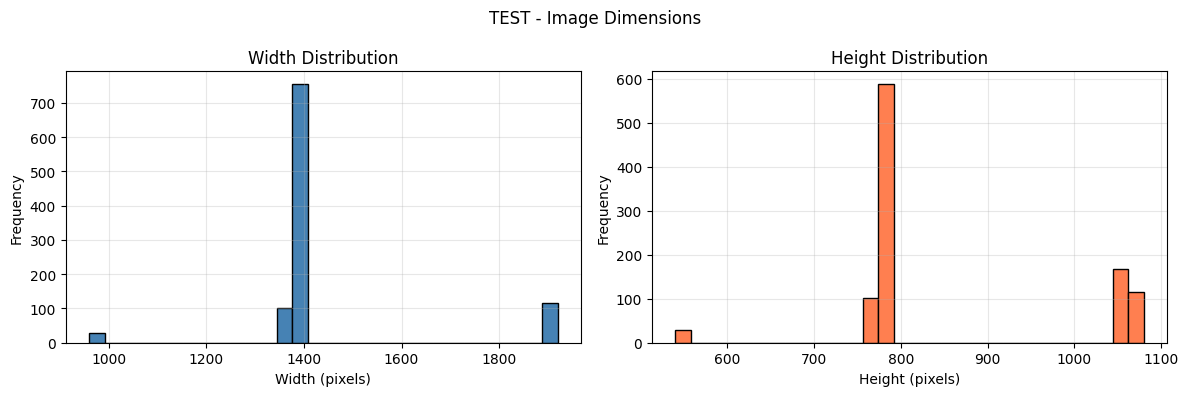

In [10]:
def get_image_sizes(image_files, max_samples=1000):
    """Get image dimensions"""
    widths = []
    heights = []
    
    sample_files = random.sample(image_files, min(max_samples, len(image_files)))
    
    for img_path in sample_files:
        img = cv2.imread(str(img_path))
        if img is not None:
            h, w = img.shape[:2]
            widths.append(w)
            heights.append(h)
    
    return widths, heights

for split, stats in all_stats.items():
    widths, heights = get_image_sizes(stats['image_files'])
    
    print(f"\n{split.upper()} Image Sizes:")
    print(f"  Average: {np.mean(widths):.0f} x {np.mean(heights):.0f}")
    print(f"  Min: {np.min(widths):.0f} x {np.min(heights):.0f}")
    print(f"  Max: {np.max(widths):.0f} x {np.max(heights):.0f}")
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'{split.upper()} - Image Dimensions')
    
    axes[0].hist(widths, bins=30, color='steelblue', edgecolor='black')
    axes[0].set_title('Width Distribution')
    axes[0].set_xlabel('Width (pixels)')
    axes[0].set_ylabel('Frequency')
    axes[0].grid(alpha=0.3)
    
    axes[1].hist(heights, bins=30, color='coral', edgecolor='black')
    axes[1].set_title('Height Distribution')
    axes[1].set_xlabel('Height (pixels)')
    axes[1].set_ylabel('Frequency')
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()